# Cloud Sampling

In this notebook, we will go through the post-processing steps used to estimate the slope $b$ of the cloud size distribution $\mathcal{C}$ based on the results from a high-resolution large-eddy simulation (LES). Here, clusters of cloudy regions have been defined as grid points in the LES model output field containing condensed liquid water $q_l > 0$. We have skipped the process of obtaining the clusters from the model output field, but it is a simple process of collecting contiguous regions of cloudy points.

In [ ]:
import json
import numpy as np
import pandas as pd

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model as lm
from sklearn.tree import DecisionTreeRegressor

from pathlib import Path
from rich import print

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks', 
    {
        'axes.grid': True, 
        'axes.linewidth': '1',
        'grid.color': '0.5',
        'grid.linestyle': u':',
        'legend.frameon': True,
    })
xkcd = sns.xkcd_rgb


rc_opt = {
    "figure.dpi": 300,
    "font.family": "serif",
    "font.size": 15,
    "text.usetex": False,
    'text.latex.preamble': r"\usepackage{libertine} \usepackage[libertine]{newtxmath}",
}
mpl.rcParams.update(rc_opt)

cp = sns.color_palette()

In [3]:
# Retrieve data location
try:
    with open(Path("../config.json")) as fp:
        p_data = json.load(fp)
        print(p_data)
except FileNotFoundError:
    print("Model data not found.")

{'prj_d': '/tera/users/loh/repos/nb_gp', 'case': '/Howard16TB/data/loh/CGILS_S6'}

In [4]:
p_clusters = Path(p_data['case']) / "clusters"

l_clusters = sorted(p_clusters.glob("*.pq"))
print(l_clusters[:12])

[
    PosixPath('/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_0000.pq'),
    PosixPath('/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_0001.pq'),
    PosixPath('/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_0002.pq'),
    PosixPath('/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_0003.pq'),
    PosixPath('/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_0004.pq'),
    PosixPath('/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_0005.pq'),
    PosixPath('/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_0006.pq'),
    PosixPath('/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_0007.pq'),
    PosixPath('/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_0008.pq'),
    PosixPath('/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_0009.pq'),
    PosixPath('/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_0010.pq'),
    PosixPath('/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_0011.pq')
]

Let's pick a random sample from the LES model output. The following code picks up a random sample from the list of clusters sampled at 1-minute intervals.

In [5]:
rng = np.random.default_rng()

print(pq_cluster := l_clusters[rng.integers(len(l_clusters))])
print(df := pd.read_parquet(pq_cluster))

/Howard16TB/data/loh/CGILS_S6/clusters/cloud_cluster_1126.pq

coord   cid  type
0       14967438     1     1
1       14967439     1     1
2       14967440     1     1
3       14967441     1     1
4       14968977     1     1
...          ...   ...   ...
503228  65577978   505     0
503229  65577979   505     0
503230  65579514   505     0
503231  66278422  4009     0
503232  66362896  4010     0

[2460135 rows x 3 columns]

The Dataframe contains a list of simplified coordinates of all LES grid points containing condensed liquid water. Contiguous regions of the cloud have been identified from the 3D field, so these coordinates can be grouped by their cids. 

The following code defines the cloud _sample_ as the area of each contiguous cloud region. The area $A$ can be calculated by the number of model grid points within each cloud region, multiplied by the size of the model grid point (25 $\times$ 25 $\mathrm{m}^2$).

In [6]:
df = df[df.type == 0]
df['z'] = df.coord // (1728 * 576)

df = df.groupby(['cid', 'z']).size().reset_index(name='counts')
samples = df.counts.value_counts().to_numpy() * 25 * 25

Given the cloud samples from above, we can then define cloud size distribution $\mathcal{C}$ by estimating the probability distribution of cloud size, or the area $A$ of cloud samples.

Typically, this is done by counting the number of clouds over a range of size bins and constructin a histogram. However, the choice of the bins is rather arbitrary but it has significant impact on the shape of the resulting probability distribution. The binning process also masks the information about the individual cloud samples.

Instead, we can use Kernel Density Estimation (KDE) to produce smooth density estimates based on individual cloud samples. The following code performs KDE using the Gaussian kernel and plots the resulting probability distribution on a log-log scale.

In [7]:
x_grid = np.log10(np.logspace(3, np.log10(np.max(samples)), 50))
y_data = np.log10(samples[:, None])

bw = 0.5    # Default bandwith for KDE

# use grid search cross-validation to optimize the bandwidth
params = {"bandwidth": np.linspace(1e-2, 1, 100)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(y_data)

bw = grid.best_estimator_.bandwidth
log_kde = grid.best_estimator_

kde10 = log_kde.score_samples(x_grid[:, None]) / np.log(10)

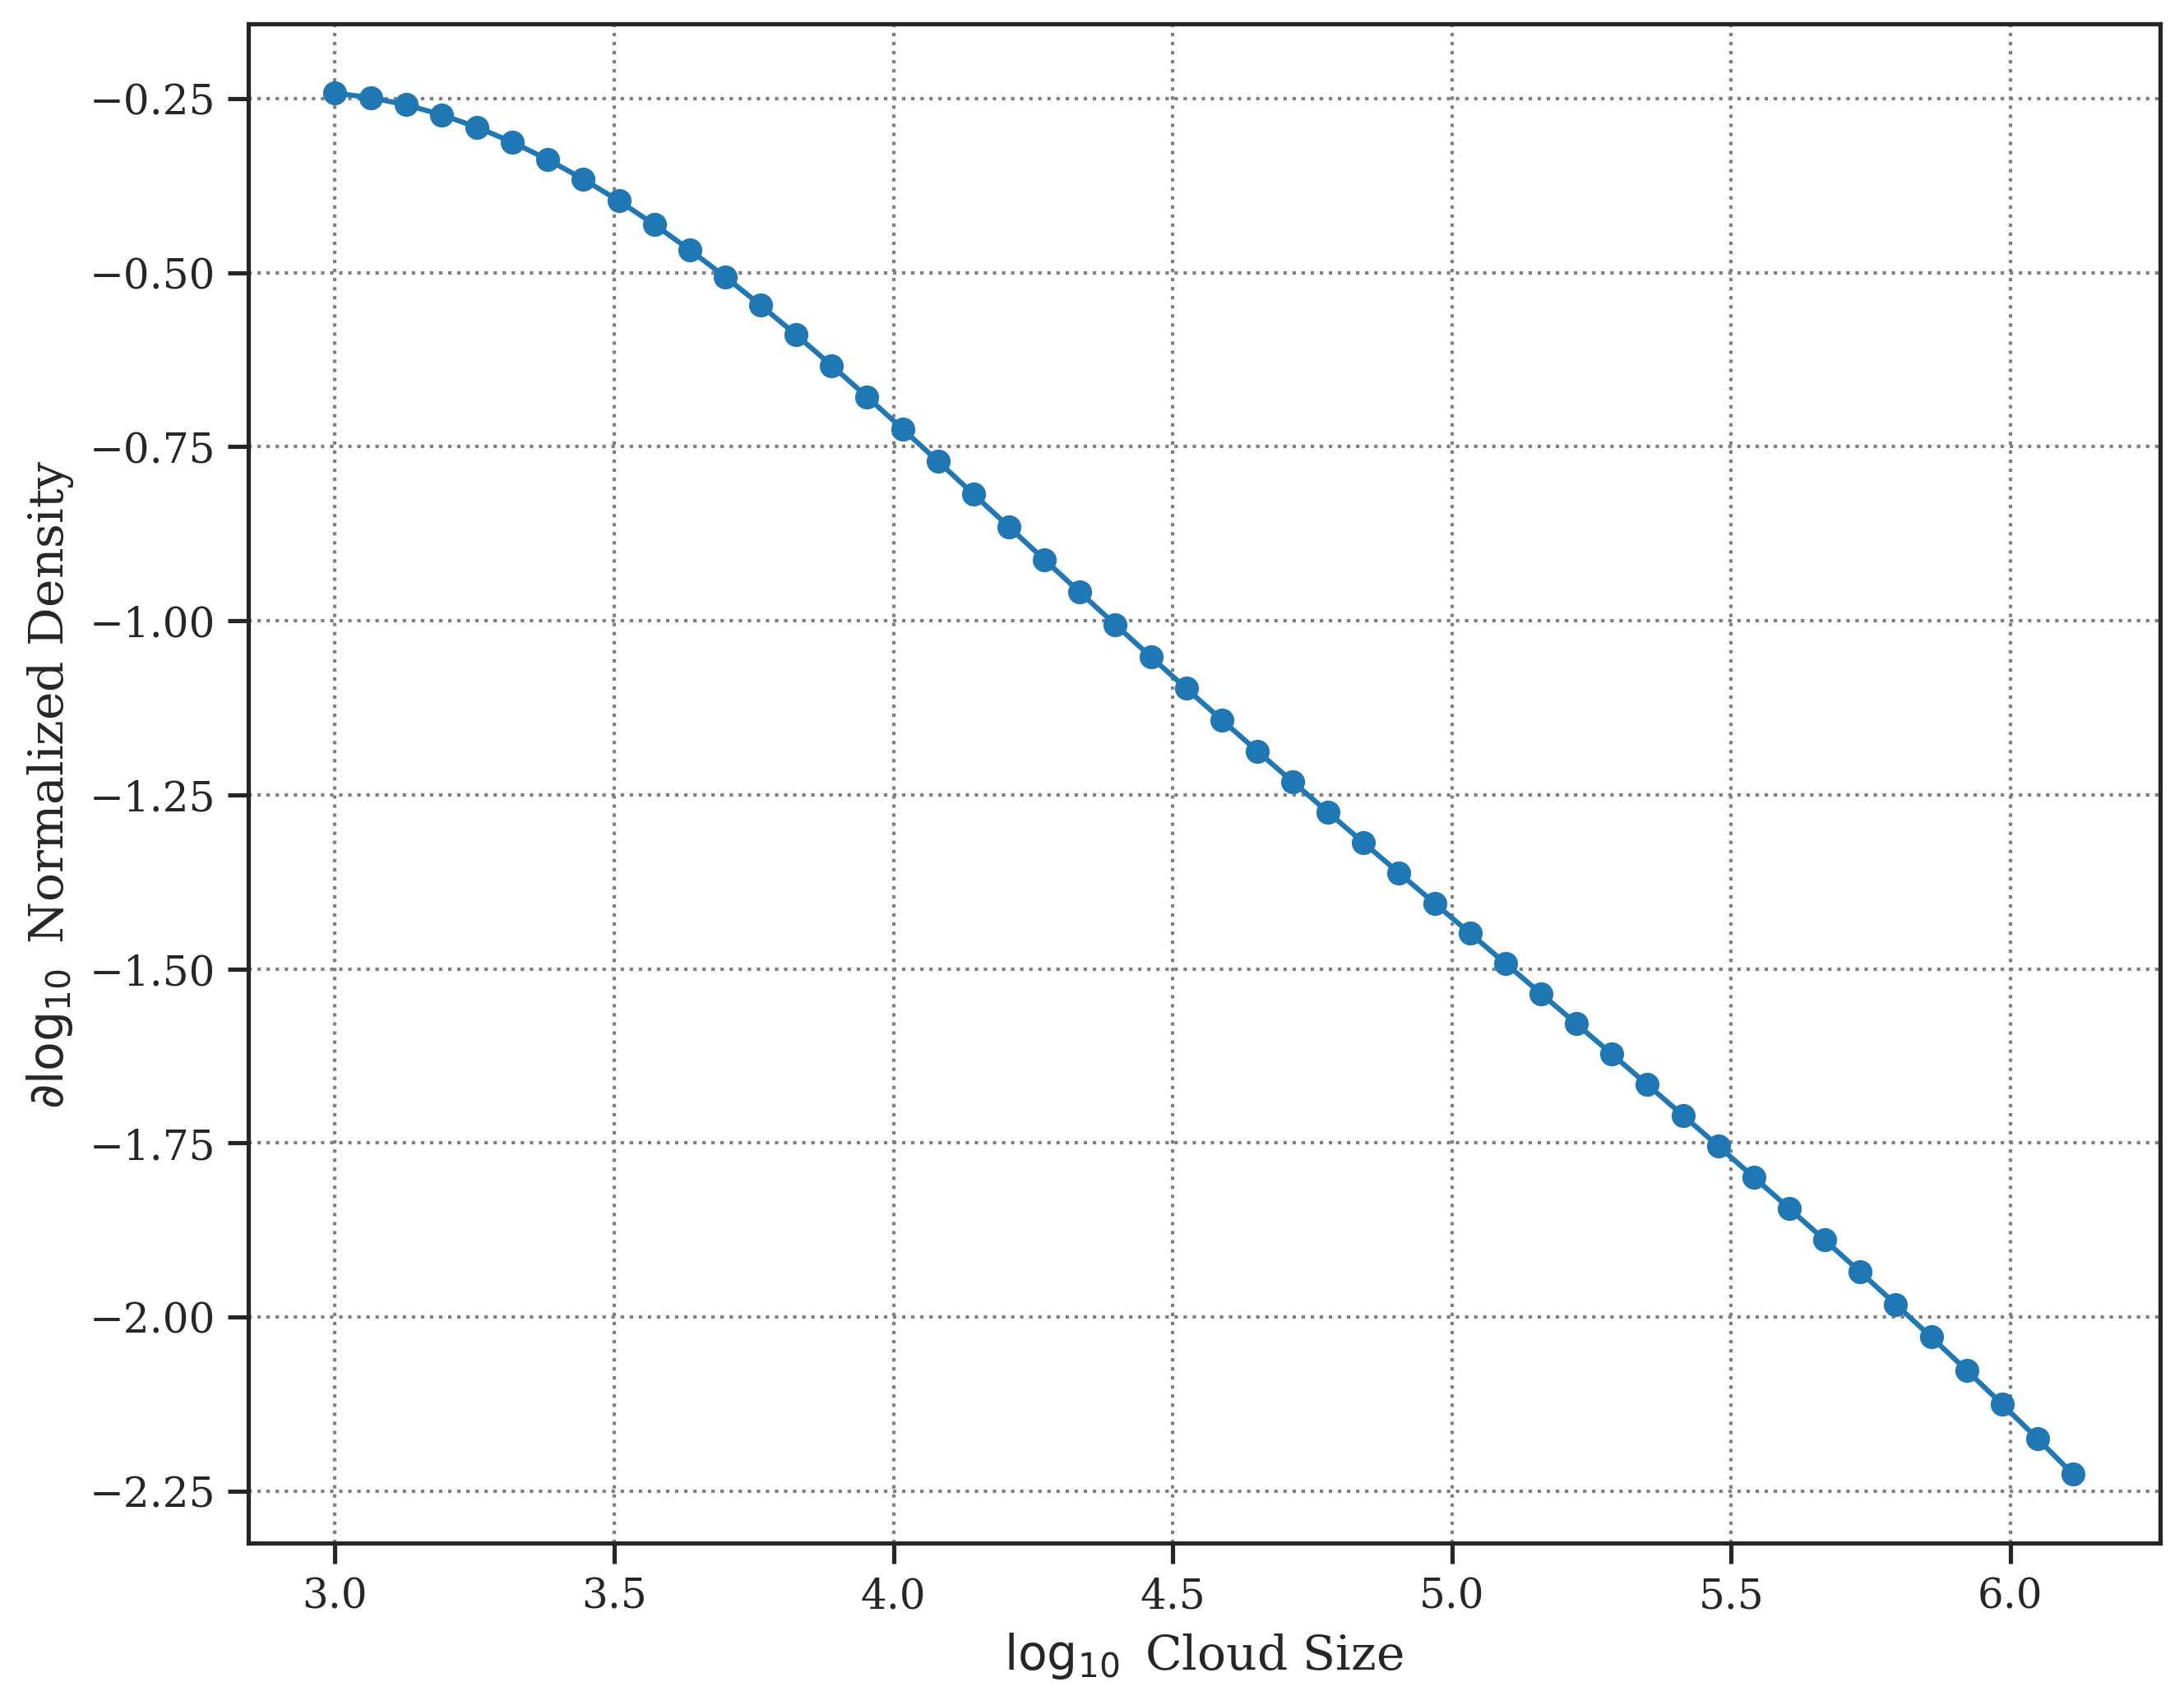

In [8]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(x_grid, kde10, "o-", c=cp[0])

ax.set_xlabel(r"$\log_{10}$ Cloud Size", fontsize=14)
ax.set_ylabel(r"$\log_{10}$ Normalized Density", fontsize=14)

ax.tick_params(axis="both", which="major", labelsize=12)


In [9]:
x = x_grid
y = kde10

tree = DecisionTreeRegressor(max_leaf_nodes=2)
tree.fit(x[:, None], np.gradient(y))
dys_dt = tree.predict(x[:, None]).flatten()

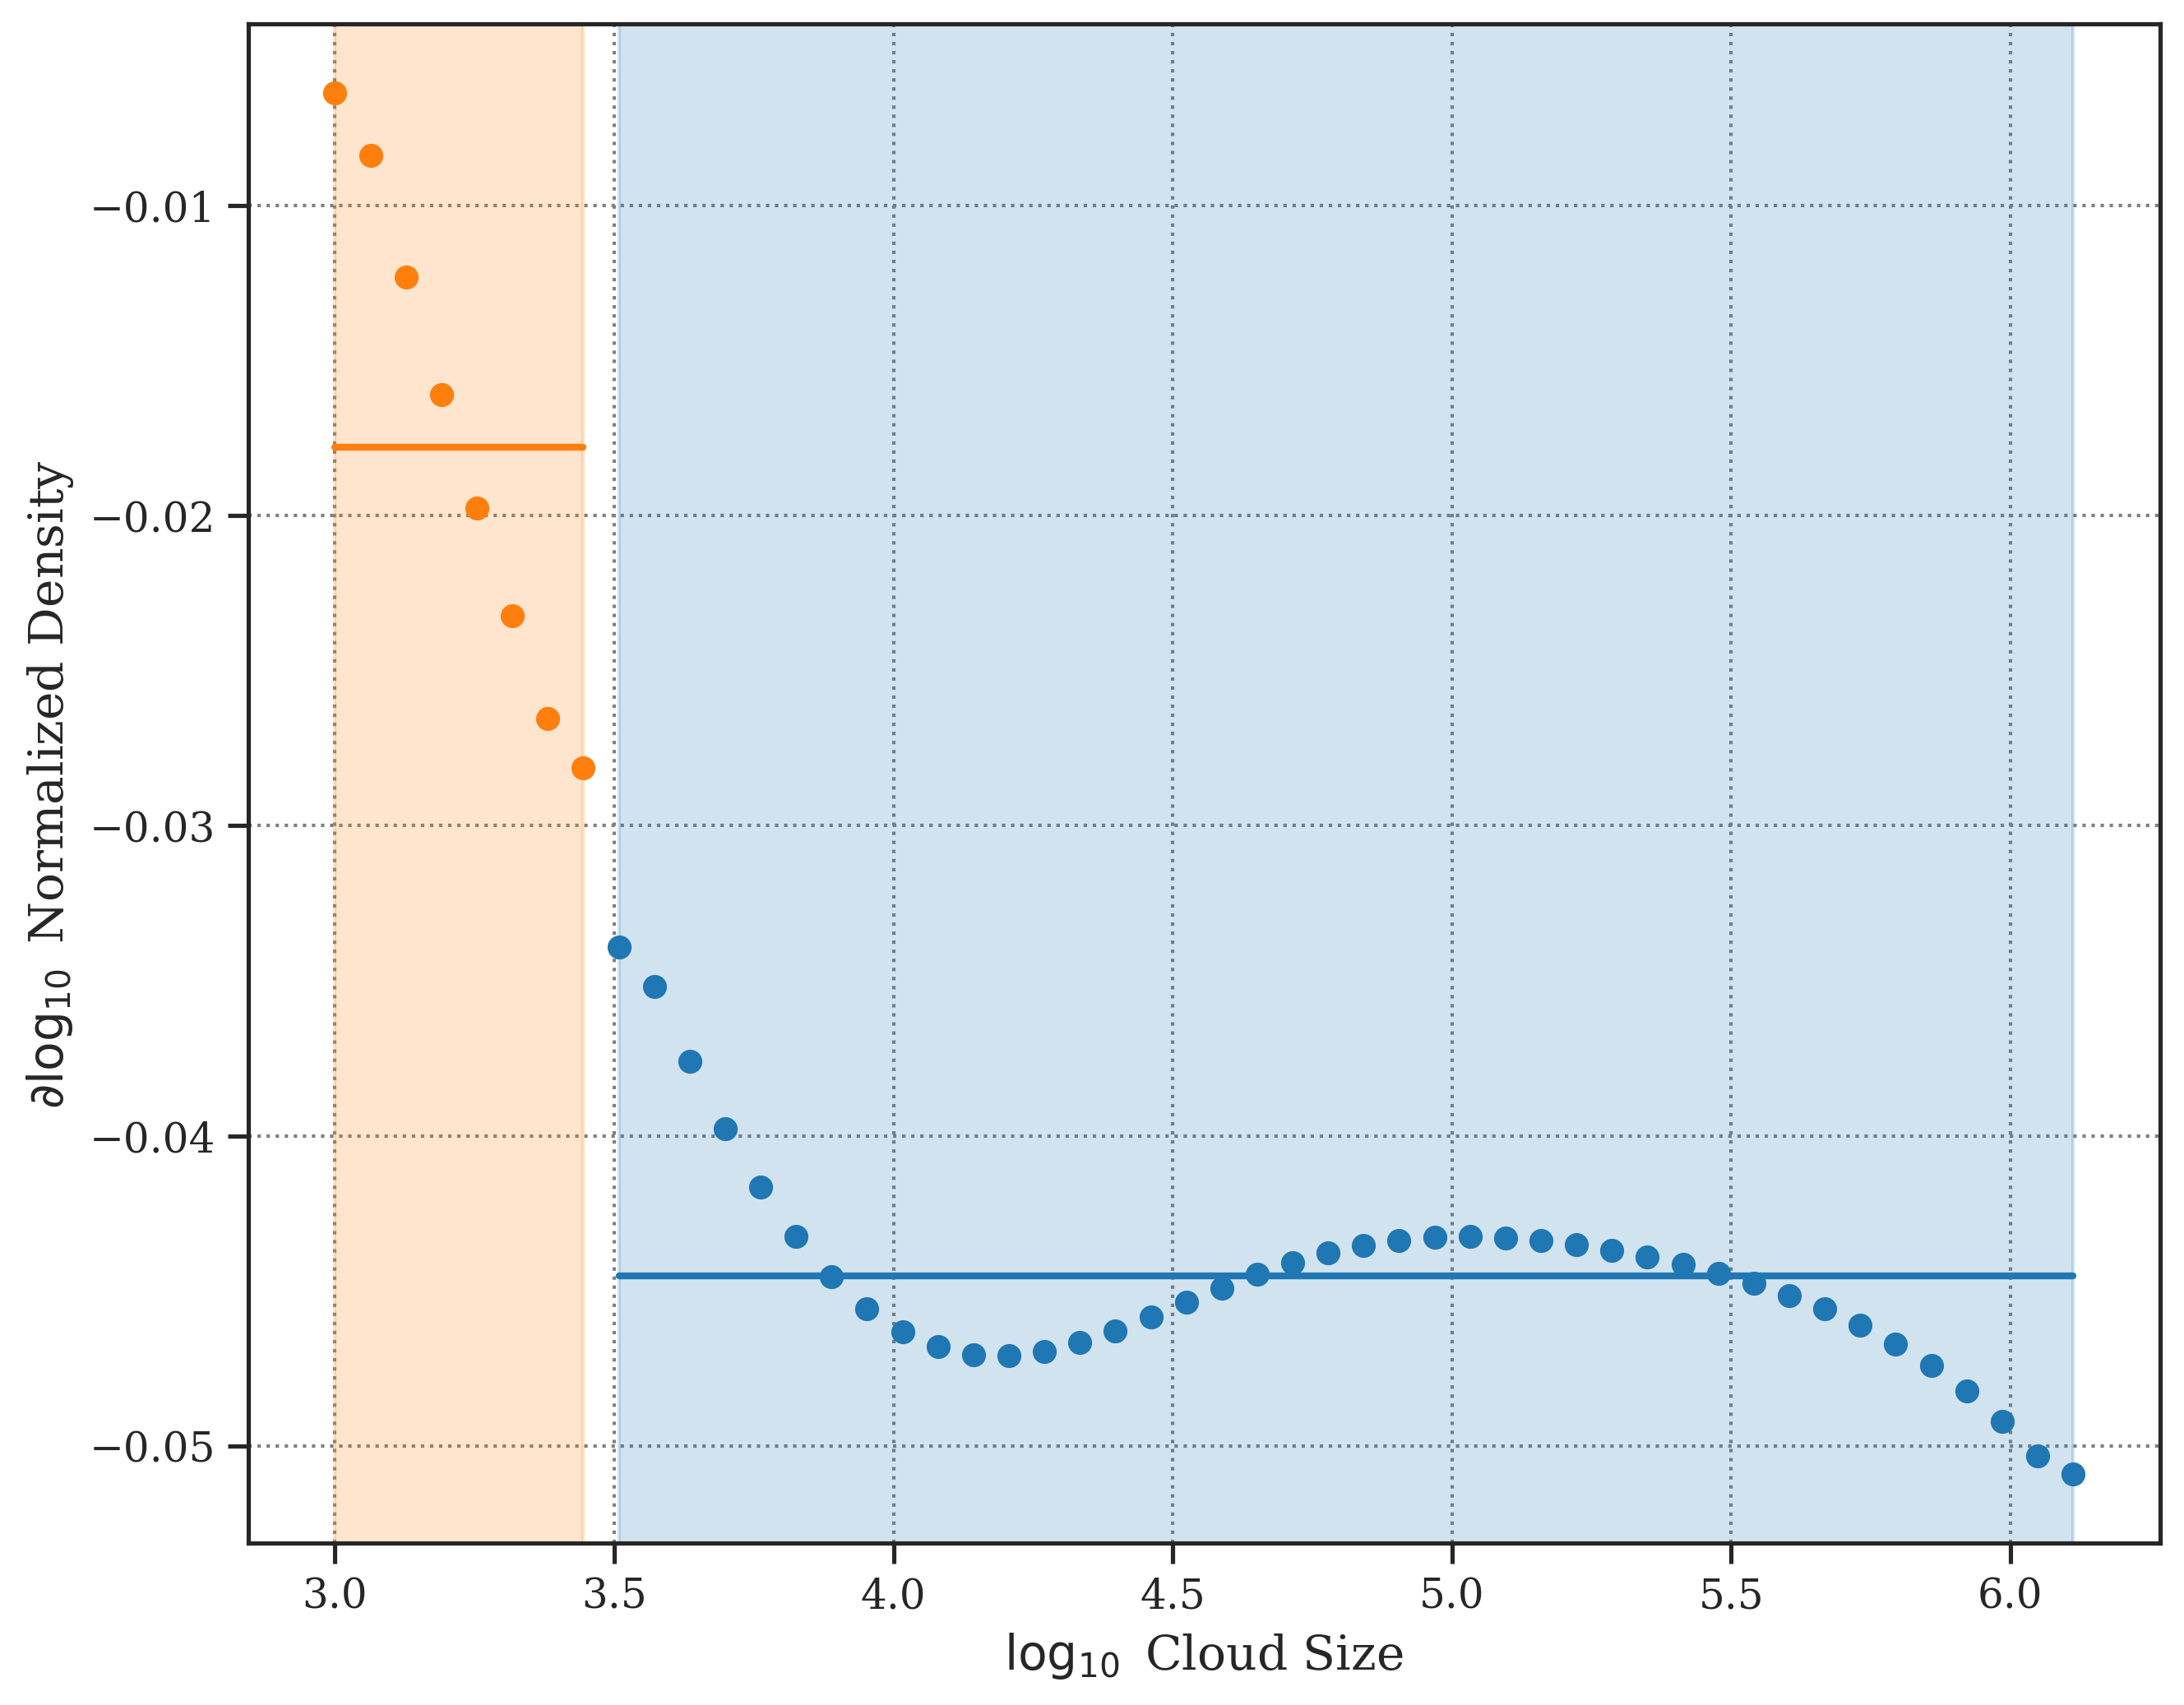

In [10]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for i, item in enumerate(np.unique(dys_dt)):
    mask = (dys_dt == item)
    c = cp[i]

    ax.plot(x[mask], np.gradient(y[mask]), ".", color=c, ms=12)
    ax.plot(x[mask], dys_dt[mask], "-", color=c, lw=2)
    ax.axvspan(x[mask][0], x[mask][-1], color=c, alpha=0.2)

ax.set_xlabel(r"$\log_{10}$ Cloud Size", fontsize=14)
ax.set_ylabel(r"$\partial \log_{10}$ Normalized Density", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

In [11]:
_, ind, c = np.unique(dys_dt, return_index=True, return_counts=True)
# Find the longest segment for regression
pt_in = ind[np.argsort(c)][::-1]
pt_in = np.append(pt_in, len(dys_dt))

x_seg = x[pt_in[0] : np.min(pt_in[pt_in > pt_in[0]])]
y_seg = y[pt_in[0] : np.min(pt_in[pt_in > pt_in[0]])]

# Regression on the linear portion of the distribution
reg = lm.TheilSenRegressor()
reg.fit(x_seg[:, None], y_seg)

y_rs = reg.predict(x[:, None])

print(f"Estimated slope = {reg.coef_.item():.6f}")


Estimated slope = -0.704695

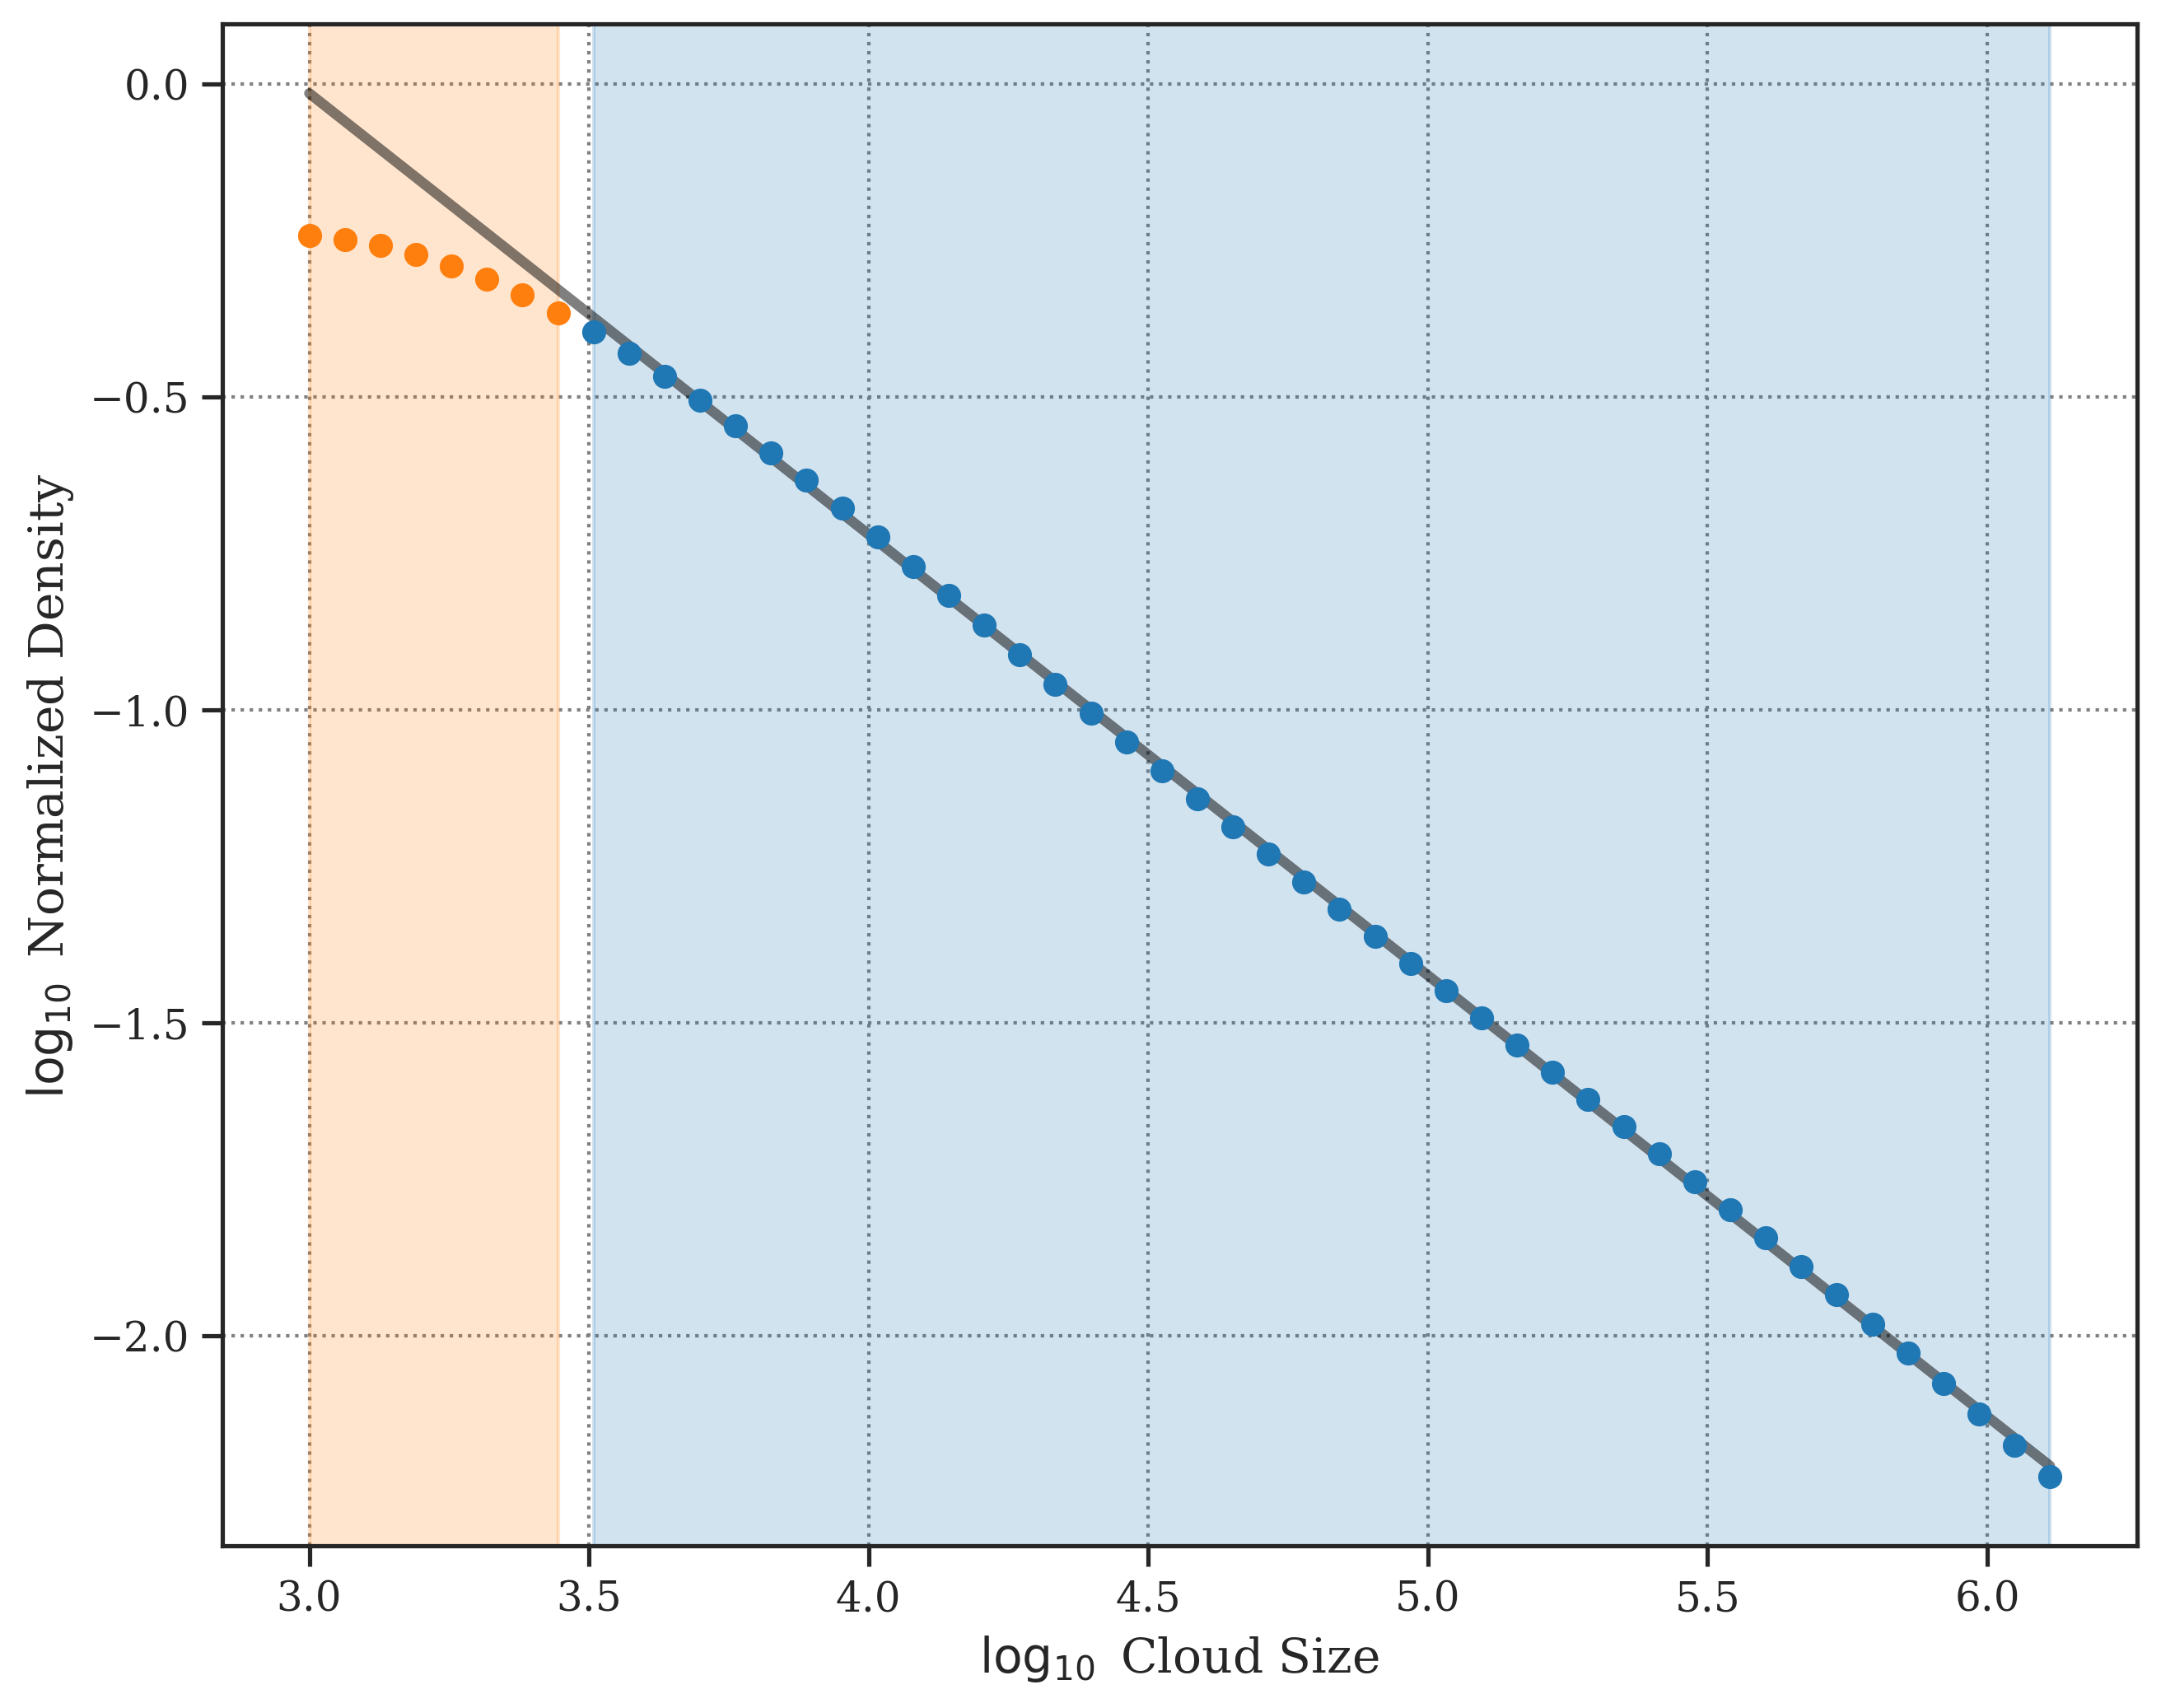

In [12]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(x, y_rs, "k-", lw=3, alpha=0.5)

for i, item in enumerate(np.unique(dys_dt)):
    mask = (dys_dt == item)
    c = cp[i]

    ax.plot(x[mask], y[mask], ".", color=c, ms=12)
    ax.axvspan(x[mask][0], x[mask][-1], color=c, alpha=0.2)

ax.set_xlabel(r"$\log_{10}$ Cloud Size", fontsize=14)
ax.set_ylabel(r"$\log_{10}$ Normalized Density", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

We then repeat this process for the entire model run. For the CGILS_S6 case, we will take last 12 hours of the simulation. The first 9 hours of the observation will be used for training, and the rest for testing in the next notebook. The following is the resulting time-series from this sampling process for the observed data.

In [13]:
p = Path('../pq/slope_CGILS_S6_CLD_KDE_PIECEWISE.pq')
df = pd.read_parquet(p)

y = df.slope.to_numpy()[:720]
x = np.arange(len(y))

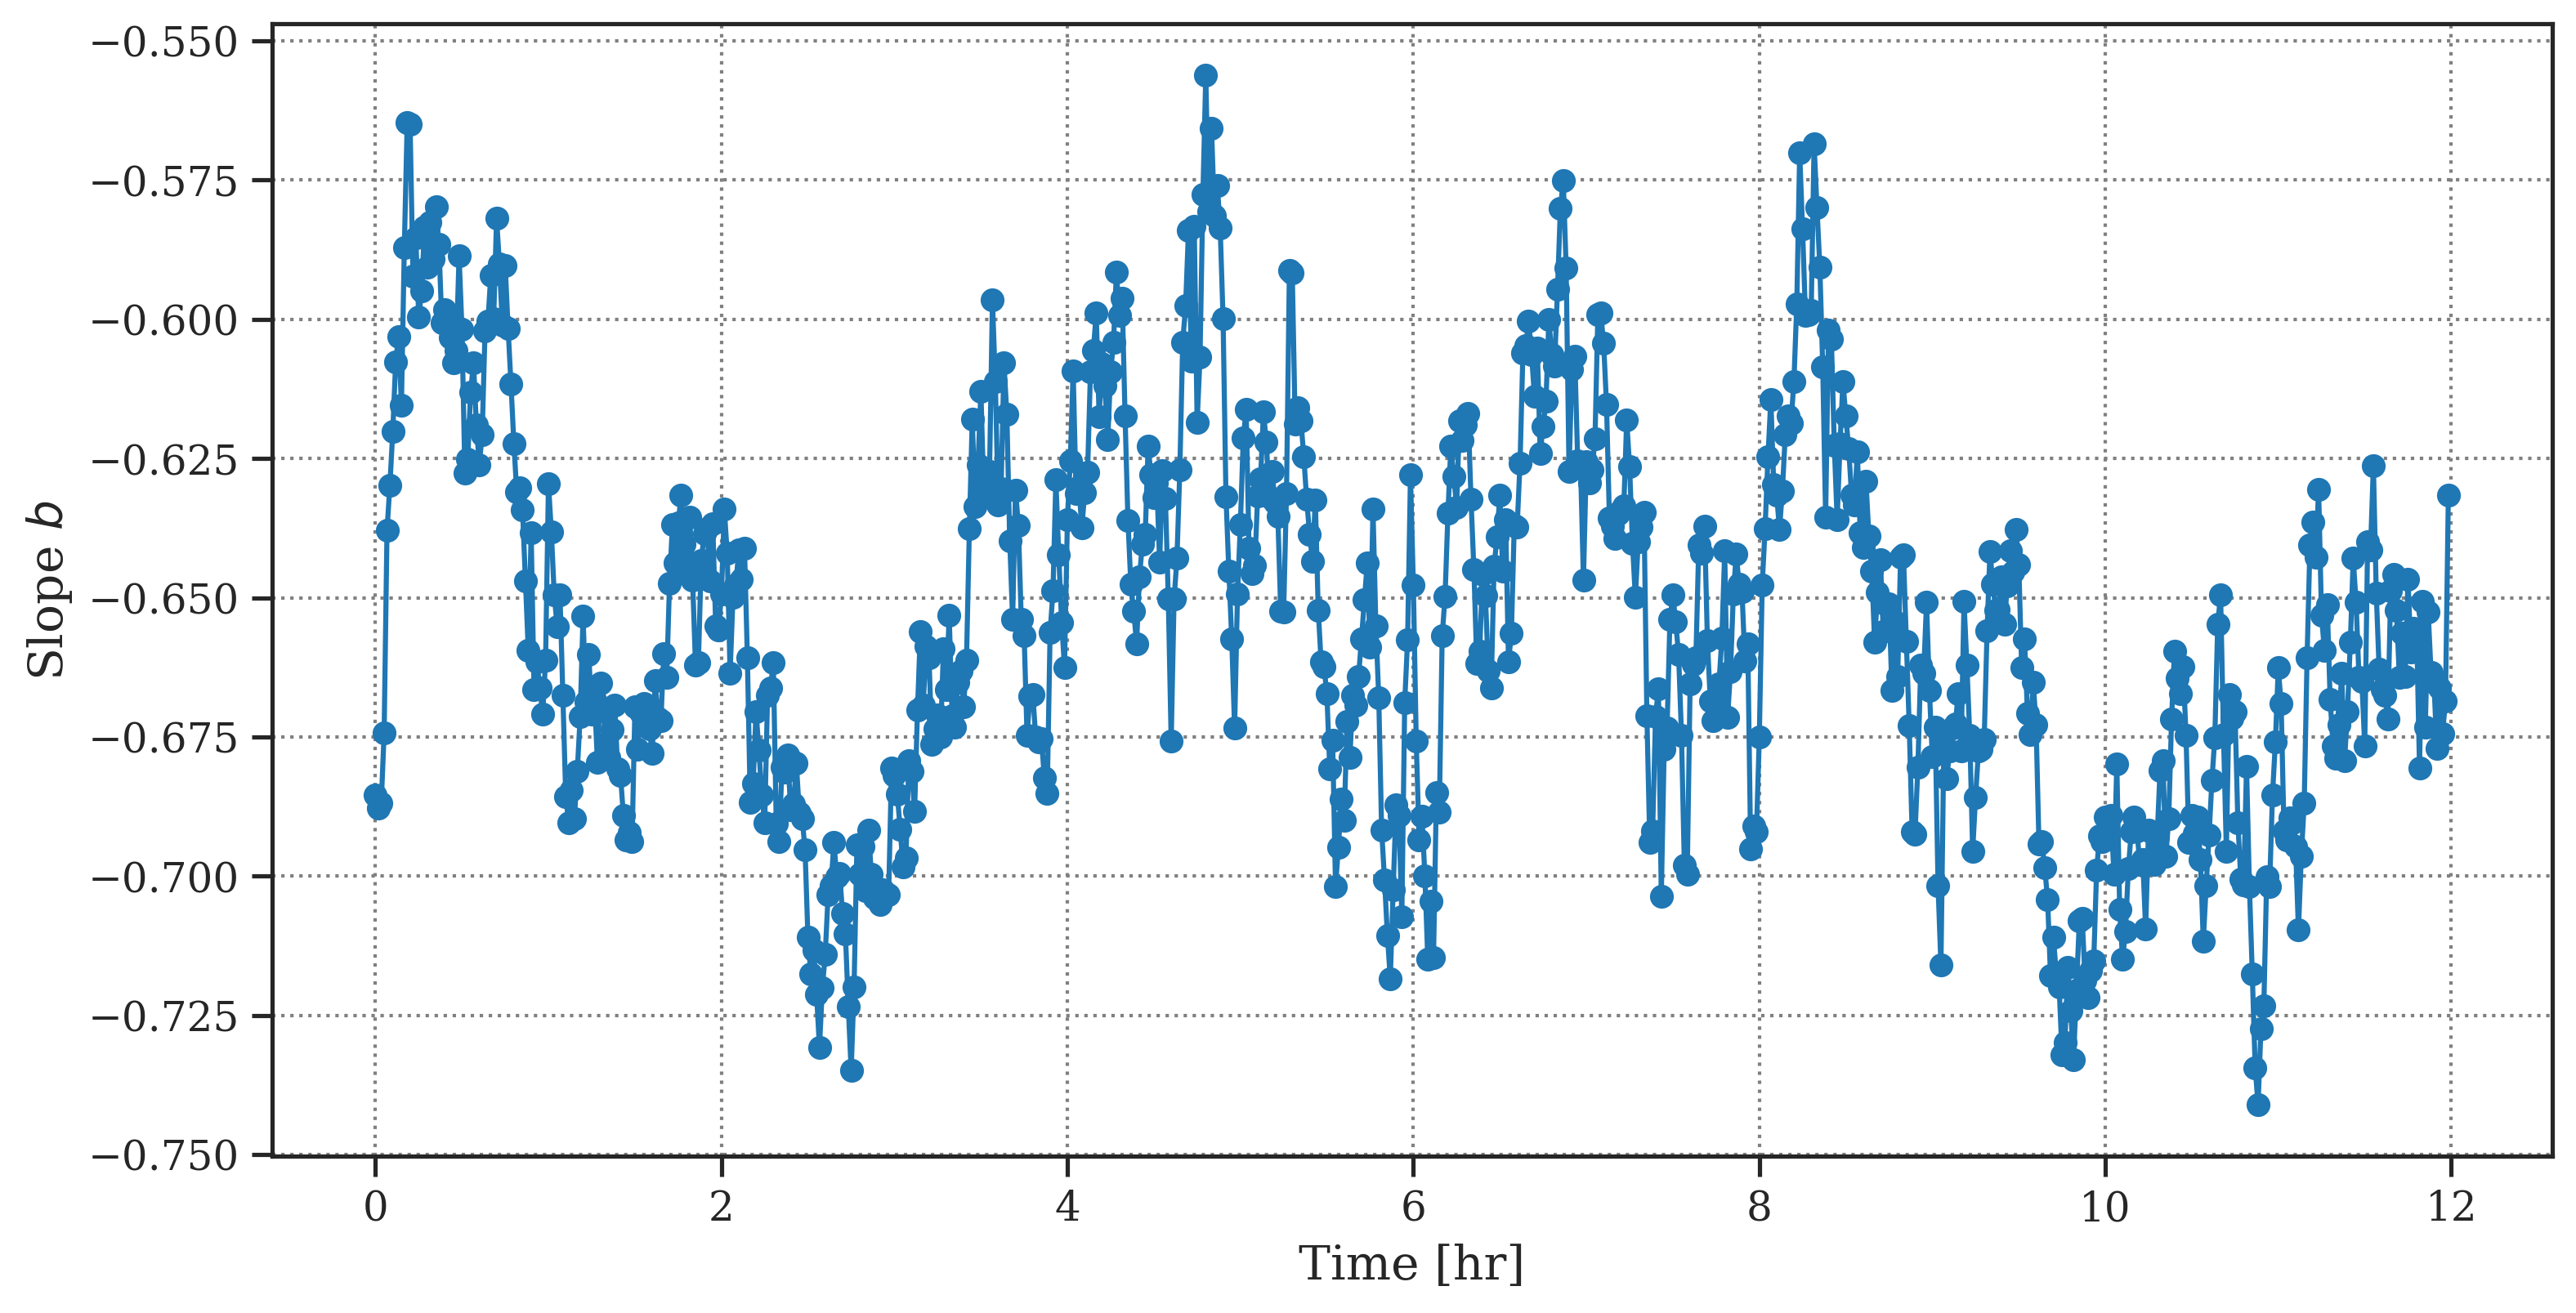

In [14]:
# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.plot(x / 60, y, 'o-')

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)